Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/forecasting-beer-remote/auto-ml-forecasting-beer-remote.png)

# Automated Machine Learning
**Beer Production Forecasting**

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Evaluate](#Evaluate)

## Introduction
This notebook demonstrates demand forecasting for Beer Production Dataset using AutoML.

AutoML highlights here include using Deep Learning forecasts, Arima, Prophet,  Remote Execution and Remote Inferencing, and working with the `forecast` function. Please also look at the additional forecasting notebooks, which document lagging, rolling windows, forecast quantiles, other ways to use the forecast function, and forecaster deployment.

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

Notebook synopsis:

1. Creating an Experiment in an existing Workspace
2. Configuration and remote run of AutoML for a time-series model exploring Regression learners, Arima, Prophet and DNNs
4. Evaluating the fitted model using a rolling test 

## Setup


In [1]:
%env AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
%env AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true

env: AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
env: AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true


In [2]:
import azure.ml
from azure.ml import MLClient

from azure.core.exceptions import ResourceExistsError

from azure.ml.entities import Workspace
from azure.ml.entities import AmlCompute
from azure.ml.entities import Data

import pandas as pd
from pandas.tseries.frequencies import to_offset
from matplotlib import pyplot as plt

In [5]:
# import os
# import azureml.core
# import pandas as pd
# import numpy as np
# import logging
# import warnings

# from pandas.tseries.frequencies import to_offset

# # Squash warning messages for cleaner output in the notebook
# warnings.showwarning = lambda *args, **kwargs: None

# from azureml.core.workspace import Workspace
# from azureml.core.experiment import Experiment
# from azureml.train.automl import AutoMLConfig
# from matplotlib import pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from azureml.train.estimator import Estimator

This sample notebook may use features that are not available in previous versions of the Azure ML SDK.

In [6]:
# TODO: Versions need to change
print("This notebook was created using version 1.31.0 of the Azure ML SDK")
print("You are currently using SDK version", azure.ml.version.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.31.0 of the Azure ML SDK
You are currently using SDK version 0.0.86 of the Azure ML SDK


As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.

In [3]:
subscription_id = '381b38e9-9840-4719-a5a0-61d9585e1e91'
resource_group_name = 'gasi_rg_centraleuap'
workspace_name = "gasi_ws_centraleuap"
experiment_name = "beer-remote-cpu"

client = MLClient(subscription_id, resource_group_name, default_workspace_name=workspace_name)

client

In [4]:
import mlflow

########
# TODO: The API to get tracking URI is not yet available on Worksapce object.
from azureml.core import Workspace as WorkspaceV1
ws = WorkspaceV1(workspace_name=workspace_name, resource_group=resource_group_name, subscription_id=subscription_id)
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
########

# Not sure why this doesn't work w/o the double + single quotes
# mlflow.set_tracking_uri("azureml://northeurope.experiments.azureml.net/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_neu/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_neu?")
mlflow.set_experiment(experiment_name)

print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.



Current tracking uri: azureml://master.experiments.azureml-test.net/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap?


### Using AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for your AutoML run. In this tutorial, you use `AmlCompute` as your training compute resource.

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

In [7]:
# Set or create compute

cpu_cluster_name = "cpu-cluster"
compute = AmlCompute(
    name=cpu_cluster_name, size="STANDARD_D2_V2",
    min_instances=0, max_instances=3,
    idle_time_before_scale_down=120
)

# Load directly from YAML file
# compute = Compute.load("./compute.yaml")

try:
    # TODO: This currently results in an exception in Azure ML, please create compute manually.
    client.compute.create(compute)
except ResourceExistsError as re:
    print(re)
except Exception as e:
    import traceback
    
    print("Could not create compute.", str(e))
#     traceback.print_exc()
    # Reload an existing compute target
    compute = client.compute.get(cpu_cluster_name)

compute

Could not create compute. 'NoneType' object has no attribute 'properties'


AmlCompute({'name': 'cpu-cluster', 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/computes/cpu-cluster', 'description': None, 'tags': {}, 'properties': {}, 'base_path': './', 'location': 'centraluseuap', 'type': 'amlcompute', 'enable_public_ip': False, 'resource_id': None, 'provisioning_state': 'Succeeded', 'provisioning_errors': None, 'created_on': None, 'size': 'STANDARD_D2_V2', 'min_instances': 0, 'max_instances': 4, 'idle_time_before_scale_down': 120.0, 'identity_type': None, 'user_assigned_identities': None, 'admin_username': 'azureuser', 'admin_password': None, 'ssh_key_value': None, 'vnet_name': None, 'subnet': None, 'priority': 'Dedicated'})

## Data
Read Beer demand data from file, and preview data.

Let's set up what we know about the dataset. 

**Target column** is what we want to forecast.

**Time column** is the time axis along which to predict.

**Time series identifier columns** are identified by values of the columns listed `time_series_id_column_names`, for example "store" and "item" if your data has multiple time series of sales, one series for each combination of store and item sold.

**Forecast frequency (freq)** This optional parameter represents the period with which the forecast is desired, for example, daily, weekly, yearly, etc. Use this parameter for the correction of time series containing irregular data points or for padding of short time series. The frequency needs to be a pandas offset alias. Please refer to [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for more information.

This dataset has only one time series. Please see the [orange juice notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales) for an example of a multi-time series dataset.

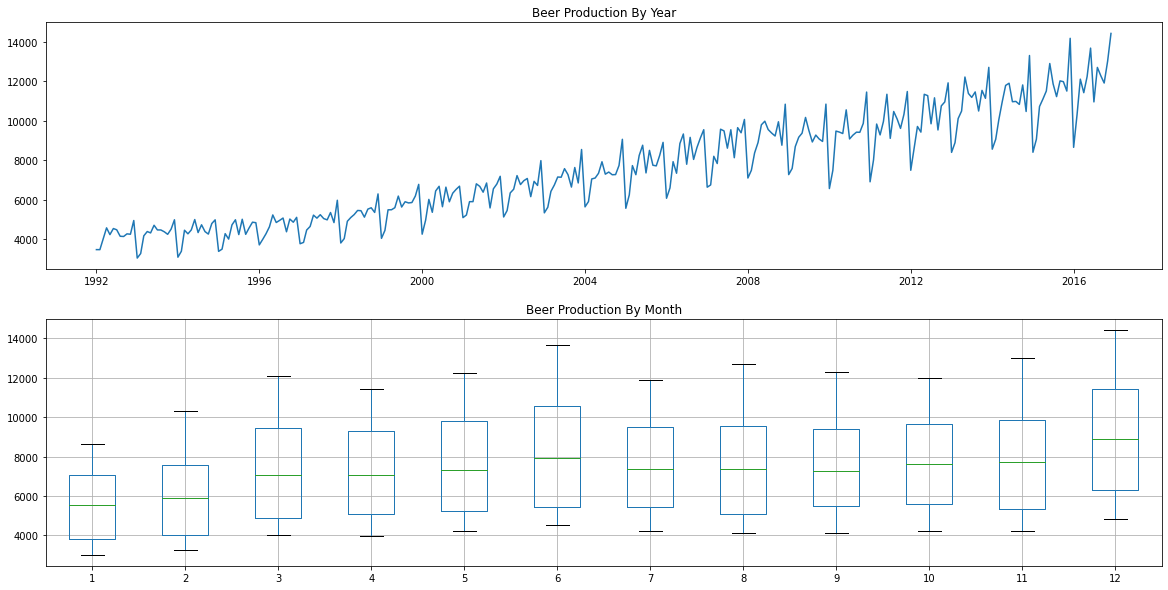

In [7]:
import pandas as pd
from pandas import DataFrame
from pandas import Grouper
from pandas import concat
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.figure(figsize=(20, 10))
plt.tight_layout()

plt.subplot(2, 1, 1)
plt.title('Beer Production By Year')
df = pd.read_csv("Beer_no_valid_split_train.csv", parse_dates=True, index_col= 'DATE').drop(columns='grain')
test_df = pd.read_csv("Beer_no_valid_split_test.csv", parse_dates=True, index_col= 'DATE').drop(columns='grain')
plt.plot(df)

plt.subplot(2, 1, 2)
plt.title('Beer Production By Month')
groups = df.groupby(df.index.month)
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,13)
months.boxplot()

plt.show()

In [9]:
target_column_name = 'BeerProduction'
time_column_name = 'DATE'
time_series_id_column_names = []
freq = 'M' #Monthly data

### Split Training data into Train and Validation set and Upload to Datastores

In [18]:
# TODO: Can't create a tabular dataset at the moment.
# Also, AzureBlobDatastore doesn't currently support uploading arbitrary files

from helper import split_fraction_by_grain
from helper import split_full_for_forecasting

train, valid = split_full_for_forecasting(df, time_column_name)
train.to_csv("train.csv")
valid.to_csv("valid.csv")
test_df.to_csv("test.csv")

datastore = client.datastores.get_default()
datastore.upload_files(files = ['./train.csv'], target_path = 'beer-dataset/', overwrite = True,show_progress = True)
datastore.upload_files(files = ['./valid.csv'], target_path = 'beer-dataset/', overwrite = True,show_progress = True)
datastore.upload_files(files = ['./test.csv'], target_path = 'beer-dataset/', overwrite = True,show_progress = True)

# from azureml.core import Dataset
# train_dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'beer-dataset/train.csv')])
# valid_dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'beer-dataset/valid.csv')])
# test_dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'beer-dataset/test.csv')])

AttributeError: 'AzureBlobDatastore' object has no attribute 'upload_files'

In [24]:
# TODO: This doesnt' work, ensure dataset is created via. the UI
# Create dataset

dataset_name = "beertrain"
dataset_version = 1

try:
    train_dataset = client.data.get(dataset_name, dataset_version)
except Exception as e:
    print("Could not create dataset. ", str(e))

train_dataset

Data({'is_anonymous': False, 'name': 'beertrain', 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/data/beertrain/versions/1', 'description': None, 'tags': {}, 'properties': {'_TimeSeries_Column:FineGrainTimestamp_': 'DATE'}, 'base_path': './', 'creation_context': <azure.ml._restclient.v2021_03_01_preview.models._models_py3.SystemData object at 0x7f328730ba10>, 'version': 1, 'datastore': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/datastores/workspaceblobstore', 'path': 'beer-dataset/train.csv', 'local_path': None})

In [25]:
# TODO: This doesnt' work, ensure dataset is created via. the UI
# Create dataset

dataset_name = "beervalid"
dataset_version = 1

try:
    valid_dataset = client.data.get(dataset_name, dataset_version)
except Exception as e:
    print("Could not create dataset. ", str(e))

training_data

Data({'is_anonymous': False, 'name': 'beertrain', 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/data/beertrain/versions/1', 'description': None, 'tags': {}, 'properties': {'_TimeSeries_Column:FineGrainTimestamp_': 'DATE'}, 'base_path': './', 'creation_context': <azure.ml._restclient.v2021_03_01_preview.models._models_py3.SystemData object at 0x7f328587d190>, 'version': 1, 'datastore': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/datastores/workspaceblobstore', 'path': 'beer-dataset/train.csv', 'local_path': None})

### Setting forecaster maximum horizon 

The forecast horizon is the number of periods into the future that the model should predict. Here, we set the horizon to 12 periods (i.e. 12 months). Notice that this is much shorter than the number of months in the test set; we will need to use a rolling test to evaluate the performance on the whole test set. For more discussion of forecast horizons and guiding principles for setting them, please see the [energy demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand).  

In [8]:
forecast_horizon = 12

## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**enable_dnn**|Enable Forecasting DNNs|


In [31]:
from azure.ml._restclient.v2020_09_01_preview.models import (
    GeneralSettings,
    DataSettings,
    LimitSettings,
    TrainingDataSettings,
    ValidationDataSettings,
    TestDataSettings,
    FeaturizationSettings,
)

from azure.ml.entities._job.automl.training_settings import TrainingSettings
from azure.ml.entities._job.automl.featurization import FeaturizationSettings
from azure.ml.entities import AutoMLJob, ComputeConfiguration

from azure.ml.entities._job.automl.forecasting import ForecastingSettings

compute_settings = ComputeConfiguration(target=cpu_cluster_name)

forecasting_settings = ForecastingSettings(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    frequency='MS'
)

general_settings = GeneralSettings(
    task_type="forecasting",
    primary_metric= "normalized_root_mean_squared_error",
    log_verbosity="Info")

limit_settings = LimitSettings(
    timeout=60,
    trial_timeout=5,
    max_concurrent_trials=4)

training_data_settings = TrainingDataSettings(
    dataset_arm_id="{}:{}".format(train_dataset.name, train_dataset.version)
)
validation_data_settings = ValidationDataSettings(
    dataset_arm_id="{}:{}".format(valid_dataset.name, valid_dataset.version),
)

data_settings = DataSettings(
    training_data=training_data_settings,
    target_column_name=target_column_name,
    validation_data=validation_data_settings
)

training_settings = TrainingSettings(enable_dnn_training=True)

extra_automl_settings = {"save_mlflow": True}

automl_job = AutoMLJob(
    compute=compute_settings,
    general_settings=general_settings,
    limit_settings=limit_settings,
    data_settings=data_settings,
    training_settings=training_settings,
    forecasting_settings=forecasting_settings,
    properties=extra_automl_settings,
)

automl_job

AutoMLJob({'name': '681c6bfa-7604-44cb-aee9-3bb5240b77bf', 'id': None, 'description': None, 'tags': {}, 'properties': {'save_mlflow': True}, 'base_path': './', 'type': 'automl_job', 'creation_context': None, 'experiment_name': 'forecasting-beer-remote', 'status': None, 'interaction_endpoints': None, 'log_files': None, 'output': None, 'general_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.GeneralSettings object at 0x7f32857d6bd0>, 'data_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.DataSettings object at 0x7f32857d6c90>, 'limit_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.LimitSettings object at 0x7f32857d6d90>, 'forecasting_settings': <azure.ml.entities._job.automl.forecasting.ForecastingSettings object at 0x7f32857d6c50>, 'training_settings': <azure.ml.entities._job.automl.training_settings.TrainingSettings object at 0x7f32857d6950>, 'featurization_settings': None, 'compute': {'instance_count': None, 'targe

In [32]:
created_job = client.jobs.create_or_update(automl_job)
created_job

AutoMLJob({'name': '681c6bfa-7604-44cb-aee9-3bb5240b77bf', 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/jobs/681c6bfa-7604-44cb-aee9-3bb5240b77bf', 'description': None, 'tags': {}, 'properties': {'save_mlflow': 'True'}, 'base_path': './', 'type': 'automl_job', 'creation_context': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.SystemData object at 0x7f32a6496fd0>, 'experiment_name': 'forecasting-beer-remote', 'status': 'NotStarted', 'interaction_endpoints': {'Tracking': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.JobEndpoint object at 0x7f3285921690>, 'Studio': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.JobEndpoint object at 0x7f3285921150>}, 'log_files': None, 'output': None, 'general_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.GeneralSettings object at 0x7f3285921b50>, 'data_settings': <

We will now run the experiment, starting with 10 iterations of model search. The experiment can be continued for more iterations if more accurate results are required. Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [ ]:
# If you need to retrieve a run that already started, use the following code
# from azureml.train.automl.run import AutoMLRun
# remote_run = AutoMLRun(experiment = experiment, run_id = '<replace with your run id>')

Displaying the run objects gives you links to the visual tools in the Azure Portal. Go try them!

### Retrieve the Best Model for Each Algorithm
Below we select the best pipeline from our iterations. The get_output method on automl_classifier returns the best run and the fitted model for the last fit invocation. There are overloads on get_output that allow you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [5]:
from mlflow.tracking import MlflowClient

# TODO: Use this run, as it has MLFlow model stored on the run
job_name = "AutoML_b0fca464-fad5-4c96-8f57-3f38dce2d5ed"
# job_name = created_job.name

mlflow_client = MlflowClient()
mlflow_parent_run = mlflow_client.get_run(job_name)

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run_customized = mlflow_client.get_run(best_child_run_id)
best_run_customized

Found best child run id:  AutoML_b0fca464-fad5-4c96-8f57-3f38dce2d5ed_606


<Run: data=<RunData: metrics={'explained_variance': 0.8447805195931423,
 'mean_absolute_error': 537.5881970868414,
 'mean_absolute_percentage_error': 4.676106942163443,
 'median_absolute_error': 427.9120198889277,
 'normalized_mean_absolute_error': 0.06360485057818759,
 'normalized_median_absolute_error': 0.05062849265131658,
 'normalized_root_mean_squared_error': 0.07772706864579315,
 'normalized_root_mean_squared_log_error': 0.042838456892893687,
 'r2_score': 0.7972013154757737,
 'root_mean_squared_error': 656.9491841942437,
 'root_mean_squared_log_error': 0.05704935648989988,
 'spearman_correlation': 0.8609613781606004}, params={}, tags={'_aml_system_ComputeTargetStatus': '{"AllocationState":"steady","PreparingNodeCount":0,"RunningNodeCount":4,"CurrentNodeCount":4}',
 '_aml_system_automl_is_child_run_end_telemetry_event_logged': 'True',
 '_aml_system_azureml.automlComponent': 'AutoML',
 'mlflow.parentRunId': 'AutoML_b0fca464-fad5-4c96-8f57-3f38dce2d5ed',
 'mlflow.source.name': 'auto

For local inferencing, make sure we have the required libs install (e.g. TCNForecaster, fbprophet)

In [17]:
!pip install pystan==2.19.1.1
!pip install fbprophet==0.5
!pip install holidays==0.9.11

     |████████████████████████████████| 81 kB 6.8 MB/s  eta 0:00:01
  Created wheel for holidays: filename=holidays-0.9.11-py3-none-any.whl size=44779 sha256=7cced6ff3ee9d6ad843a4ef4c592e7be37d4598b231897fdd8ac58f1f3aac7eb
  Stored in directory: /home/schrodinger/.cache/pip/wheels/c7/2d/f0/1324bcf0e577829a77f2ac0f1b812e538b8349ca36b1049106
Successfully built holidays
  Attempting uninstall: holidays
    Found existing installation: holidays 0.11.1
    Uninstalling holidays-0.11.1:
      Successfully uninstalled holidays-0.11.1


In [6]:
import mlflow.sklearn

fitted_model = mlflow.sklearn.load_model("runs:/{}/outputs".format(best_run_customized.info.run_id))

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


#### TODO: Do local predictions using the model above

#### Remote inferencing

Need some form of command job for this

In [ ]:
from helper import get_result_df
summary_df = get_result_df(remote_run)
summary_df

In [ ]:
from azureml.core.run import Run
from azureml.widgets import RunDetails
forecast_model = 'TCNForecaster'
if not forecast_model in summary_df['run_id']:
    forecast_model = 'ForecastTCN'
    
best_dnn_run_id = summary_df['run_id'][forecast_model]
best_dnn_run = Run(experiment, best_dnn_run_id)

In [ ]:
best_dnn_run.parent
RunDetails(best_dnn_run.parent).show() 

In [ ]:
best_dnn_run
RunDetails(best_dnn_run).show() 

## Evaluate on Test Data

We now use the best fitted model from the AutoML Run to make forecasts for the test set.  

We always score on the original dataset whose schema matches the training set schema.

In [ ]:
from azureml.core import Dataset
test_dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'beer-dataset/tabular/test.csv')])
# preview the first 3 rows of the dataset
test_dataset.take(5).to_pandas_dataframe()

In [ ]:
compute_target = ws.compute_targets['beer-cluster']
test_experiment = Experiment(ws, experiment_name + "_test")

In [ ]:
import os
import shutil

script_folder = os.path.join(os.getcwd(), 'inference')
os.makedirs(script_folder, exist_ok=True)
shutil.copy('infer.py', script_folder)

In [ ]:
from helper import run_inference

test_run = run_inference(test_experiment, compute_target, script_folder, best_dnn_run, test_dataset, valid_dataset, forecast_horizon,
                 target_column_name, time_column_name, freq)

In [ ]:
RunDetails(test_run).show()

In [ ]:
from helper import run_multiple_inferences

summary_df = run_multiple_inferences(summary_df, experiment, test_experiment, compute_target, script_folder, test_dataset, 
                  valid_dataset, forecast_horizon, target_column_name, time_column_name, freq)

In [ ]:
for run_name, run_summary in summary_df.iterrows():
    print(run_name)
    print(run_summary)
    run_id = run_summary.run_id
    test_run_id = run_summary.test_run_id
    test_run = Run(test_experiment, test_run_id)
    test_run.wait_for_completion()
    test_score = test_run.get_metrics()[run_summary.primary_metric]
    summary_df.loc[summary_df.run_id == run_id, 'Test Score'] = test_score
    print("Test Score: ", test_score)

In [ ]:
summary_df